# Sheet 5

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [2]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

/mnt/c/Users/A90072180A/Documents/Study/Germany/UniHeidelbergLecture/ML and Physics/mlph_w24-main/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

torch.Size([1196, 4096]) torch.Size([1196])


In [3]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

In [4]:
# Logistic Regression without regularization
clf = LogisticRegression(penalty=None).fit(acts_train, labels_train)
print('Score on test data (without regularization):', clf.score(acts_test, labels_test))

Score on test data (without regularization): 0.9966666666666667


### (b)

In [5]:
# load all datasets
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
acts = {}
labels = {}
for dataset_name in dataset_names:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts[dataset_name], labels[dataset_name] = dm.get('train') 

/mnt/c/Users/A90072180A/Documents/Study/Germany/UniHeidelbergLecture/ML and Physics/mlph_w24-main/sheet05/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

In [6]:
clf_nopenalty = LogisticRegression(penalty=None).fit(acts["cities"], labels["cities"])
clf_l2penalty = LogisticRegression(penalty='l2').fit(acts["cities"], labels["cities"])

print('Score without regularization:')
for dataset_name in dataset_names:
    print(f'{dataset_name}  ', clf_nopenalty.score(acts[dataset_name], labels[dataset_name]))

print('\n')
print('Score with L2 regularization:')
for dataset_name in dataset_names:
    print(f'{dataset_name}  ', clf_l2penalty.score(acts[dataset_name], labels[dataset_name]))

Score without regularization:
cities   1.0
neg_cities   0.49581939799331104
sp_en_trans   0.8056537102473498
neg_sp_en_trans   0.4876325088339223


Score with L2 regularization:
cities   0.9974916387959866
neg_cities   0.49581939799331104
sp_en_trans   0.9893992932862191
neg_sp_en_trans   0.4876325088339223


### (c)

In [7]:
acts_train = torch.cat((acts["cities"], acts["neg_cities"]), dim=0)
labels_train = torch.cat((labels["cities"], labels["neg_cities"]), dim=0)

clfng_l2penalty = LogisticRegression(penalty='l2').fit(acts_train, labels_train)
dataset_names = ["sp_en_trans", "neg_sp_en_trans"]

print('Score trained on both cities and neg_cities dataset with L2 regularization:')
for dataset_name in dataset_names:
    print(f'{dataset_name}  ', clfng_l2penalty.score(acts[dataset_name], labels[dataset_name]))


Score trained on both cities and neg_cities dataset with L2 regularization:
sp_en_trans   1.0
neg_sp_en_trans   0.950530035335689


## 3 Log-sum-exp and soft(arg)max
### (b)

/tmp/ipykernel_29592/968940311.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax[i].contour(s1, s2, lse, levels=15, label='lse')


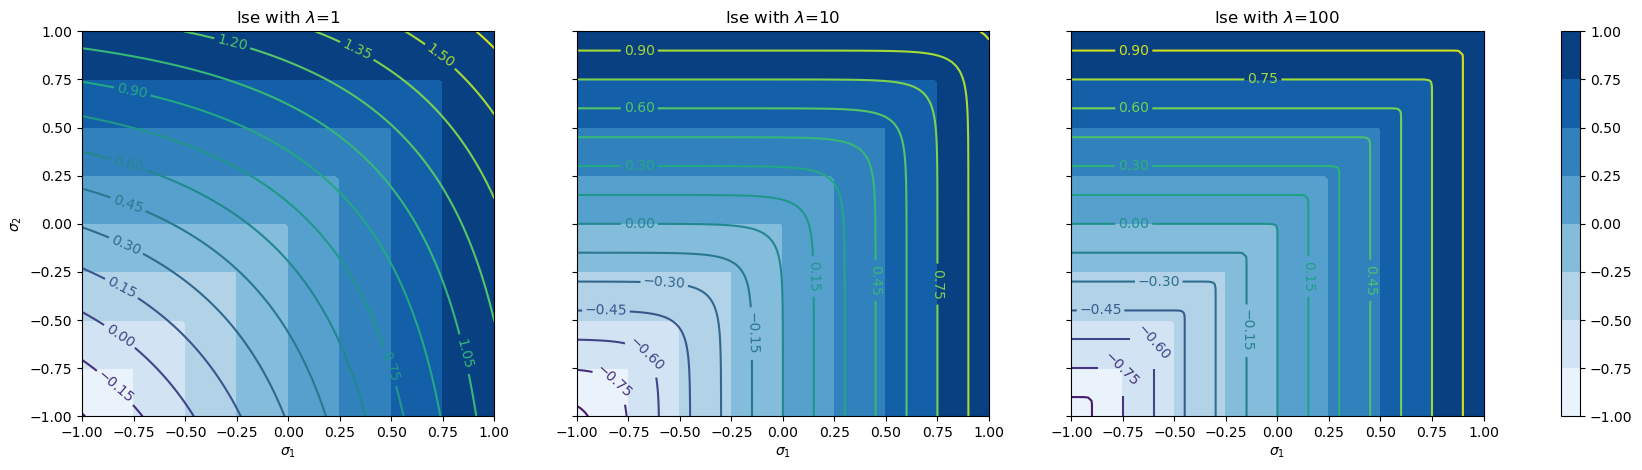

In [8]:

s1, s2 = np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)
ss = np.stack(np.meshgrid(s1, s2, indexing='ij'), axis=-1)

fig, ax = plt.subplots(ncols=3, figsize=(20, 5), sharey=True, )
for i, l in enumerate((1, 10, 100)):
    lse = 1/l * np.log(np.sum(np.exp(l * ss), axis=-1))
    cs1 = ax[i].contour(s1, s2, lse, levels=15, label='lse')
    ax[i].clabel(cs1)
    cs2 = ax[i].contourf(s1, s2, np.max(ss, axis=-1), cmap=plt.cm.Blues)
    ax[i].set_xlabel(r'$\sigma_1$')
    ax[i].set_title(r'lse with $\lambda$=' + str(l))
ax[0].set_ylabel(r'$\sigma_2$')
fig.colorbar(cs2, ax=ax, fraction=0.046, shrink=1)
plt.show()

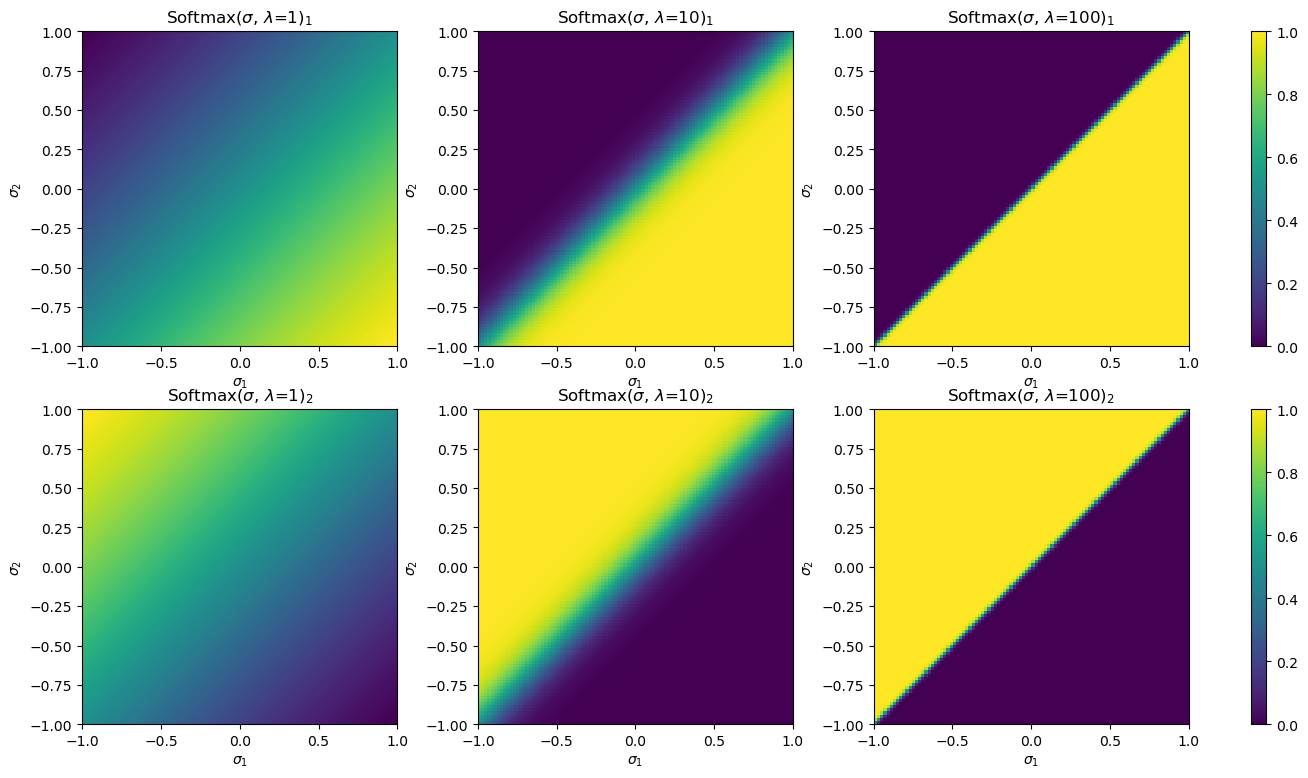

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 9))
for i, l in enumerate((1, 10, 100)):
    softmax1 = np.exp(l*s1) / np.sum(np.exp(l * ss), axis=-1)
    softmax2 = np.exp(l*s2) / np.sum(np.exp(l * ss), axis=-1)
    softmax2 = softmax2.T

    cs1 = ax[0][i].imshow(softmax1, origin='lower', extent=[-1,1,-1,1])
    cs2 = ax[1][i].imshow(softmax2, origin='lower', extent=[-1,1,-1,1])
    ax[0][i].set_xlabel(r'$\sigma_1$')
    ax[1][i].set_xlabel(r'$\sigma_1$')
    ax[0][i].set_ylabel(r'$\sigma_2$')
    ax[1][i].set_ylabel(r'$\sigma_2$')
    ax[0][i].set_title(r'Softmax($\sigma$, $\lambda$=' + str(l) +r'$)_1$')
    ax[1][i].set_title(r'Softmax($\sigma$, $\lambda$=' + str(l) +r'$)_2$')
fig.colorbar(cs1, ax=ax[0,:], fraction=0.046, shrink=1)
fig.colorbar(cs2, ax=ax[1,:], fraction=0.046, shrink=1)
    

### (c)

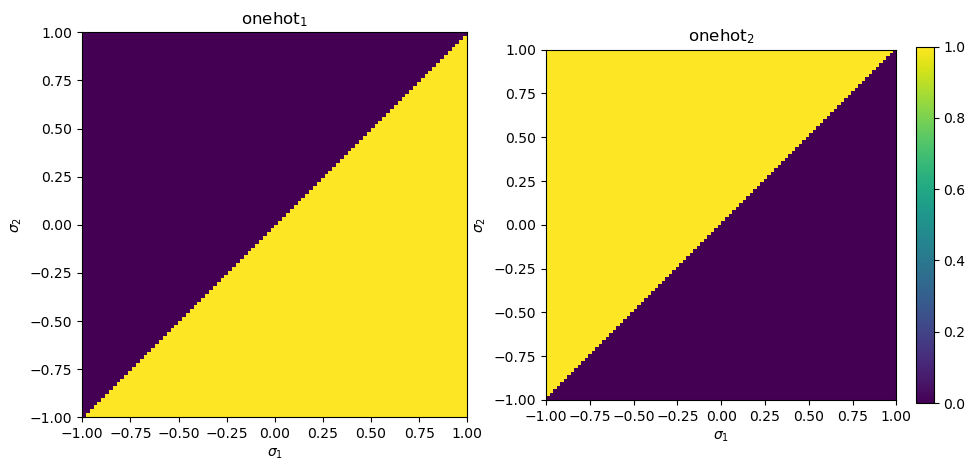

In [10]:
onehot1 = np.argmax(ss, axis=-1)
onehot2 = np.argmin(ss, axis=-1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
cs1 = ax[0].imshow(onehot1, origin='lower', extent=[-1,1,-1,1])
ax[0].set_title(r'onehot$_1$')
ax[0].set_xlabel(r'$\sigma_1$')
ax[0].set_ylabel(r'$\sigma_2$')

cs2 = ax[1].imshow(onehot2, origin='lower', extent=[-1,1,-1,1])
ax[1].set_title(r'onehot$_2$')
ax[1].set_xlabel(r'$\sigma_1$')
ax[1].set_ylabel(r'$\sigma_2$')

fig.colorbar(cs2, ax=ax[1], fraction=0.046, shrink=1)

## 4 Linear regions of MLPs

### (a)

In [11]:
#build MLP and pass it to device(CPU)
class shallowNet(nn.Module):
    def __init__(self):
        super(shallowNet, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        
        output = self.linear_relu_stack(x)
        return output
    
device = "cpu"
shallowmodel = shallowNet().to(device)

In [12]:
paramNum = 0
for name, param in shallowmodel.named_parameters():
    paramNum += param.size().numel()

print(f'Number of paramaters is {paramNum}.')

Number of paramaters is 81.


### (b) (c)

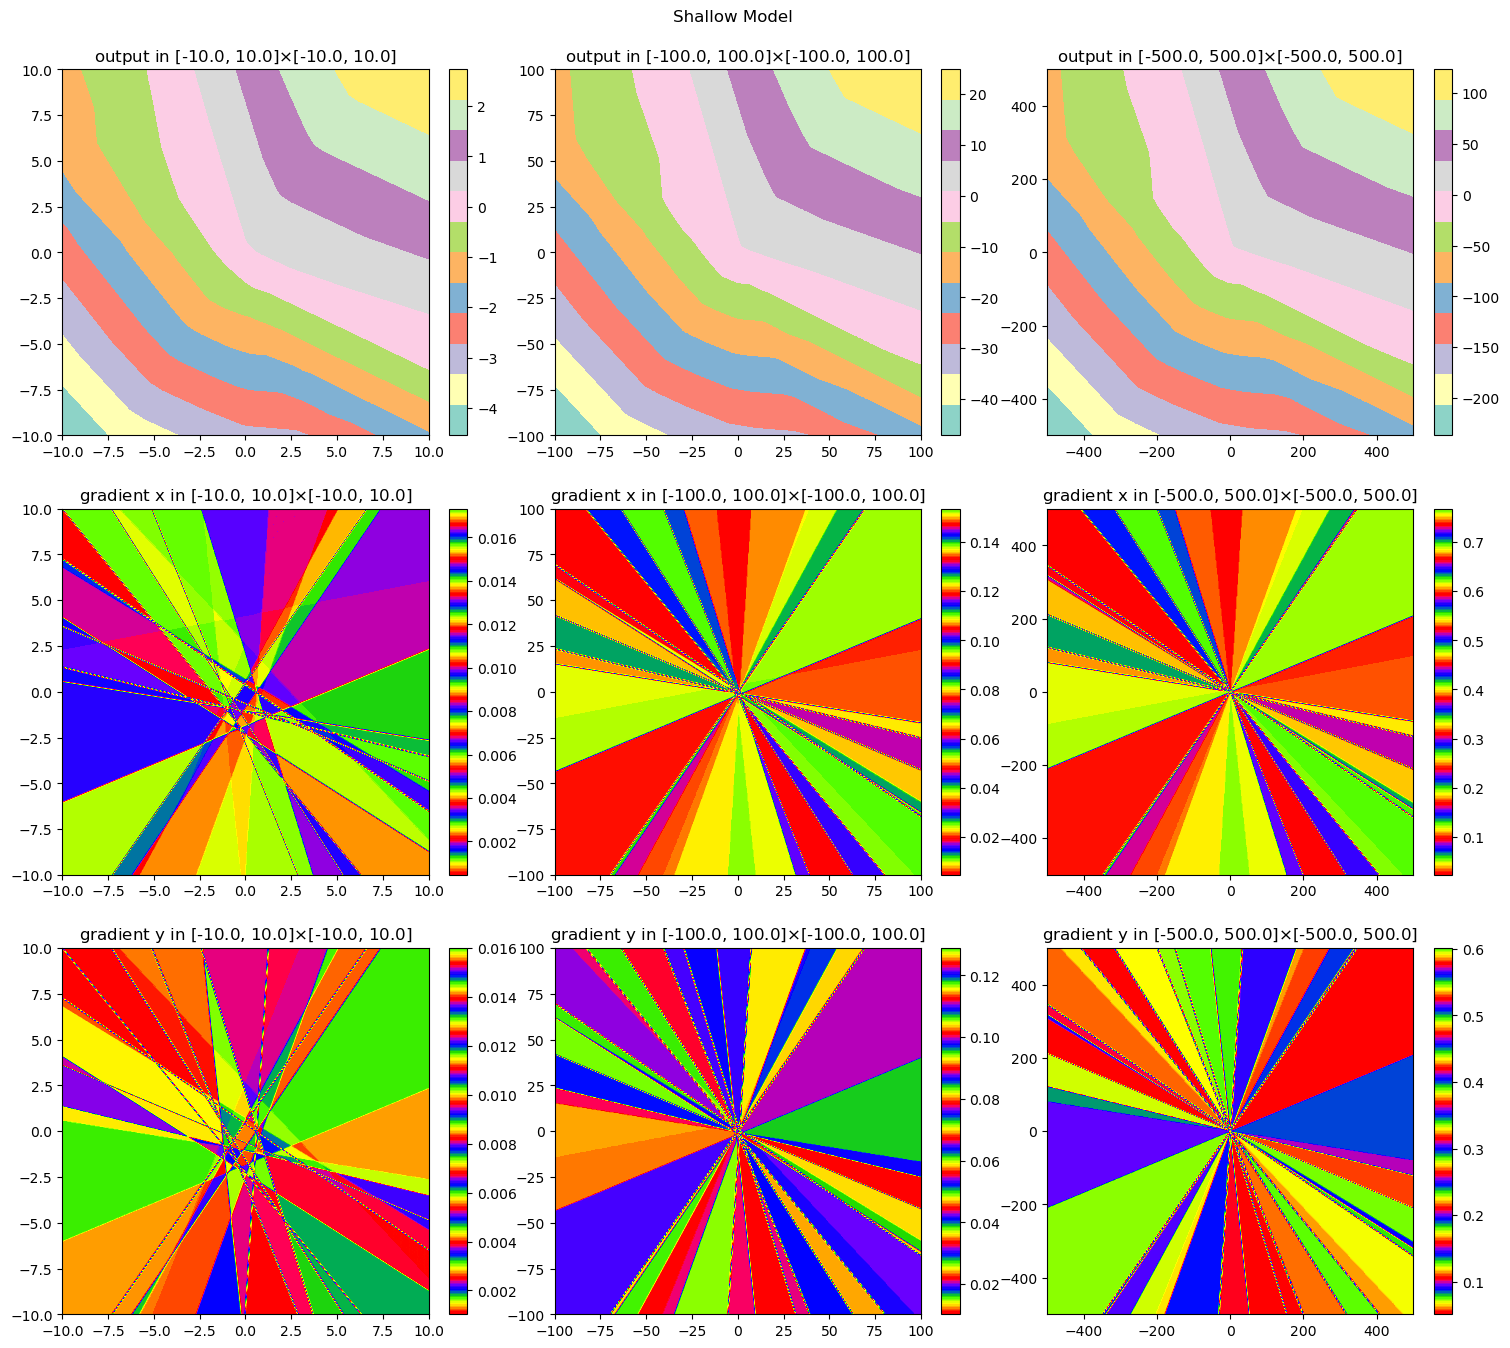

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,15))
for i, scale in enumerate((1, 10 ,50)):
    x1 = np.linspace(-10*scale, 10*scale, 500)
    x2 = np.linspace(-10*scale, 10*scale, 500)

    xg1, xg2 = np.meshgrid(x1, x2, indexing='ij')
    xs = np.stack((xg1.reshape(-1, 1), xg2.reshape(-1, 1)), axis=-1)

    x = torch.tensor(xs).float().reshape(-1, 2)
    y = shallowmodel(x).reshape(500, 500)
    y = y.detach().numpy()
    cs = ax[0][i].imshow(y, origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='Set3')
    ax[0][i].set_title(f'output in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[0][i], fraction=0.046, shrink=1)

    grad = np.gradient(y)
    cs = ax[1][i].imshow(grad[0], origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='prism')
    ax[1][i].set_title(f'gradient x in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[1][i], fraction=0.046, shrink=1)

    cs = ax[2][i].imshow(grad[1], origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='prism')
    ax[2][i].set_title(f'gradient y in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[2][i], fraction=0.046, shrink=1)

fig.suptitle('Shallow Model')
plt.subplots_adjust(top=0.94)

### (d)

In [14]:
#build MLP and pass it to device(CPU)
class deepNet(nn.Module):
    def __init__(self):
        super(deepNet, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        
        output = self.linear_relu_stack(x)
        return output
    
device = "cpu"
deepmodel = deepNet().to(device)

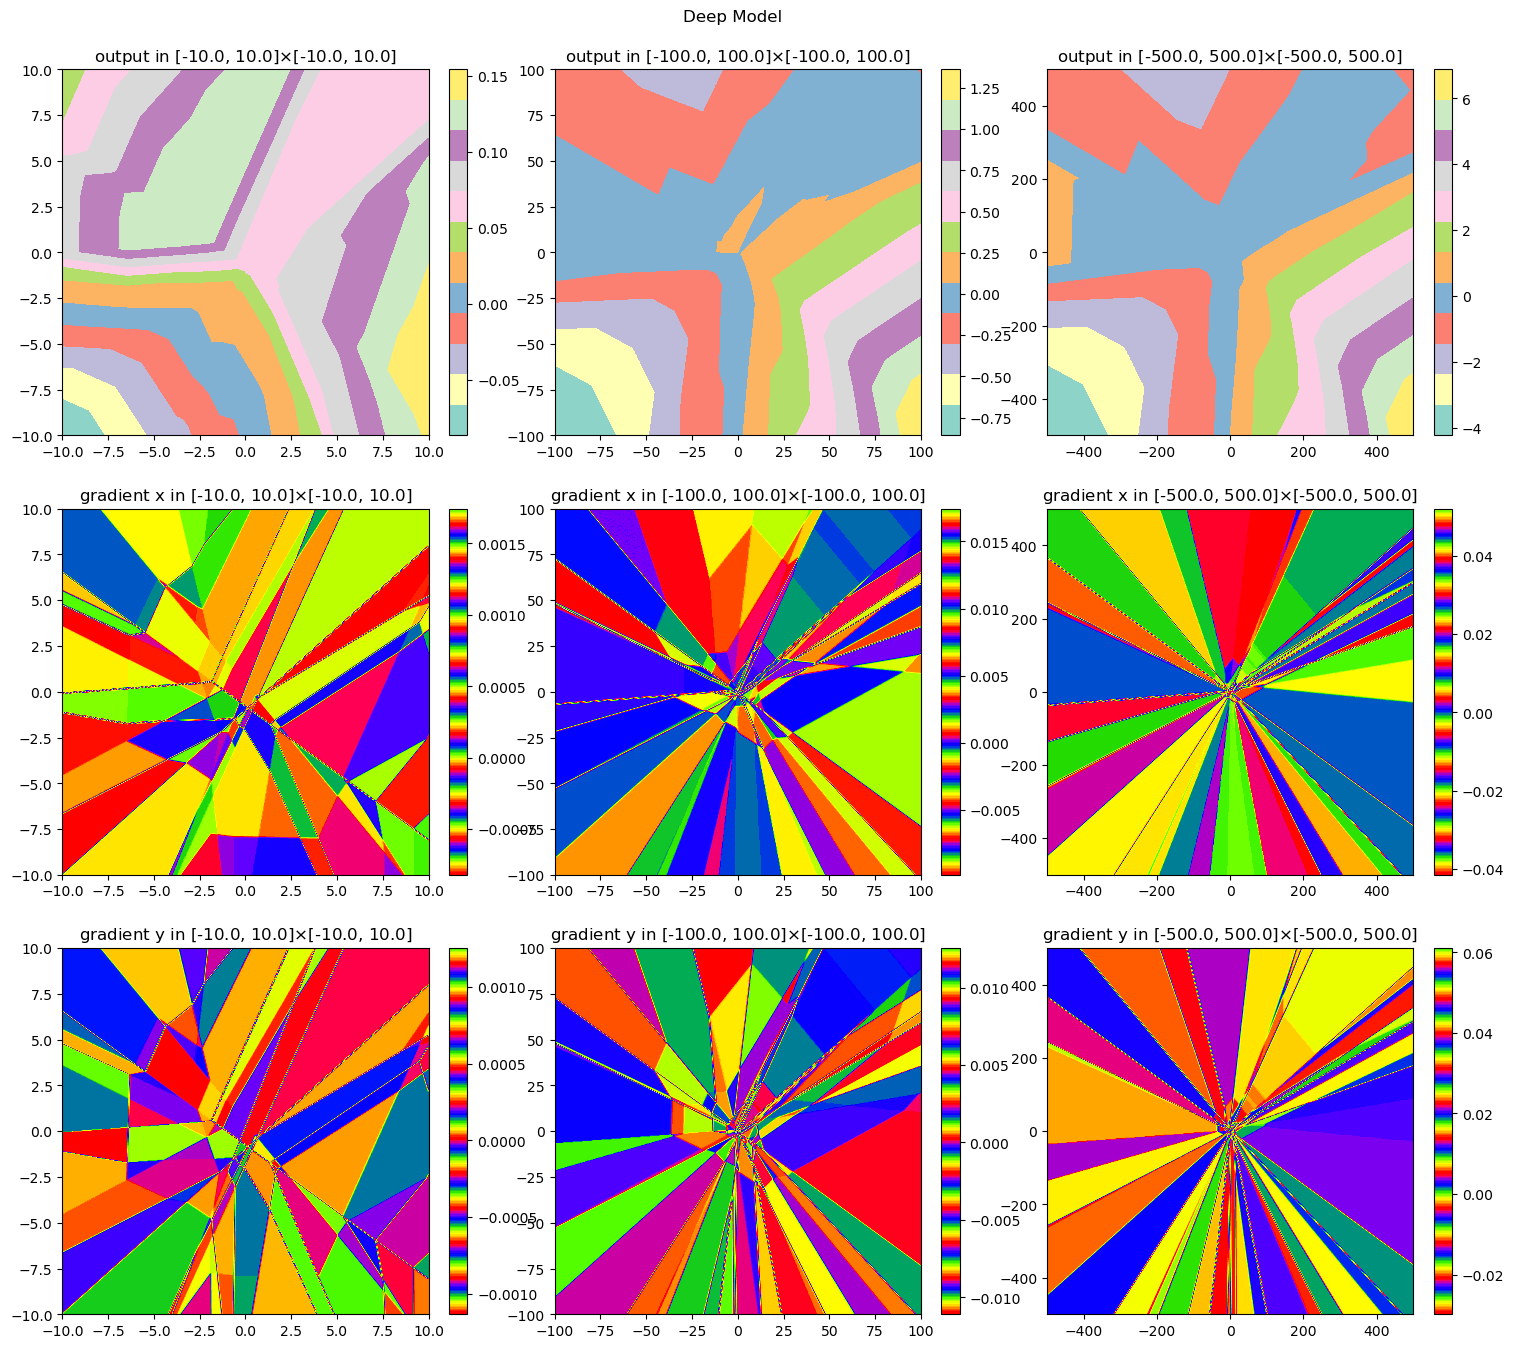

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,15))
for i, scale in enumerate((1, 10 ,50)):
    x1 = np.linspace(-10*scale, 10*scale, 500)
    x2 = np.linspace(-10*scale, 10*scale, 500)

    xg1, xg2 = np.meshgrid(x1, x2, indexing='ij')
    xs = np.stack((xg1.reshape(-1, 1), xg2.reshape(-1, 1)), axis=-1)

    x = torch.tensor(xs).float().reshape(-1, 2)
    y = deepmodel(x).reshape(500, 500)
    y = y.detach().numpy()
    cs = ax[0][i].imshow(y, origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='Set3')
    ax[0][i].set_title(f'output in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[0][i], fraction=0.046, shrink=1)

    grad = np.gradient(y)
    cs = ax[1][i].imshow(grad[0], origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='prism')
    ax[1][i].set_title(f'gradient x in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[1][i], fraction=0.046, shrink=1)

    cs = ax[2][i].imshow(grad[1], origin='lower', extent=[x1[0], x1[-1], x2[0], x2[-1]], cmap='prism')
    ax[2][i].set_title(f'gradient y in [{x1[0]}, {x1[-1]}]' + r'$\times$' + f'[{x2[0]}, {x2[-1]}]')
    fig.colorbar(cs, ax=ax[2][i], fraction=0.046, shrink=1)

fig.suptitle('Deep Model')
plt.subplots_adjust(top=0.94)